In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = recent[0]
print(recent_date)

2017-08-23


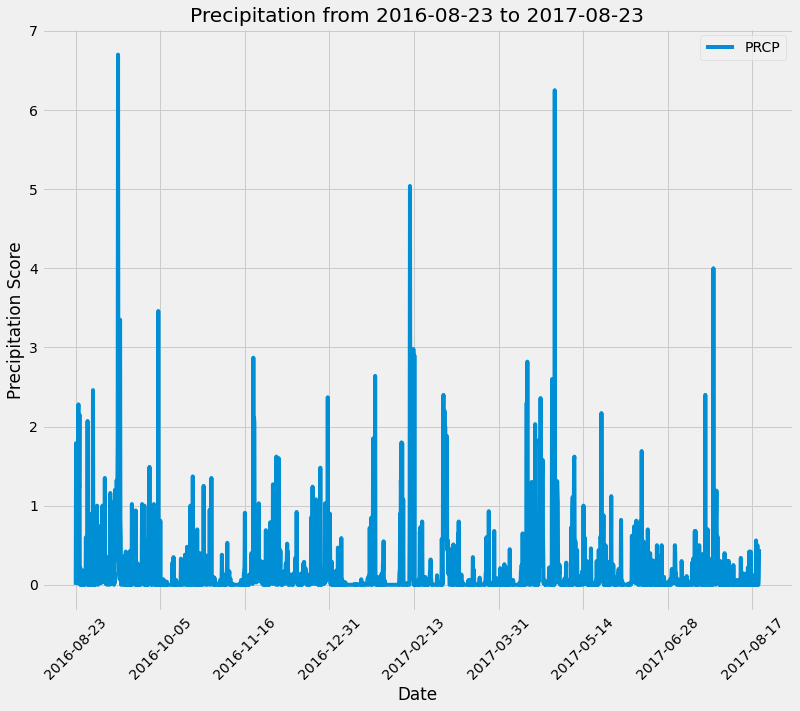

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores

# precip_data = session.query(Measurement.date,Measurement.prcp).\
#             filter(Measurement.date <= "2017-08-23").\
#             filter(Measurement.date >= (dt.date(2017,8,23)-dt.timedelta(days=365))).all()

precip_data = session.query(Measurement.date,Measurement.prcp).\
            filter(Measurement.date <= recent_date).\
            filter(Measurement.date >= year_ago).all()
           

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_rows = [{"Date": data[0],"PRCP": data[1]} for data in precip_data]
precip_df = pd.DataFrame(prcp_rows).set_index("Date").sort_values("Date",ascending=True)\
            .dropna(how="any")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(12,10),rot=45,title=f"Precipitation from {year_ago} to {recent_date}",ylabel="Precipitation Score")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(most_active)
most_active_station = most_active[0][0]
print(most_active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
USC00519281


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station==most_active_station).all()
print(stats)

[(54.0, 85.0, 71.66378066378067)]


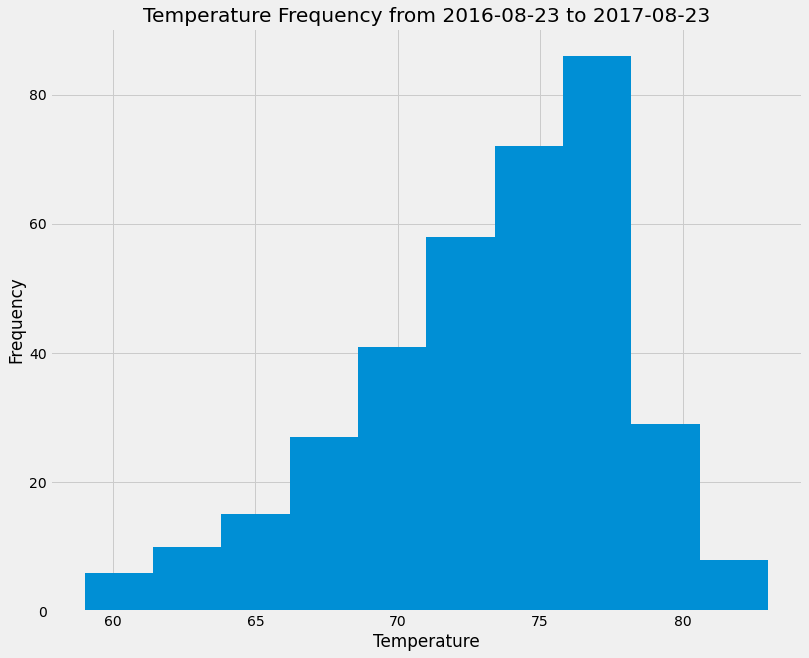

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.date,Measurement.tobs).filter(Measurement.date <= recent_date).\
            filter(Measurement.date >= year_ago).\
            filter(Measurement.station==most_active_station).all()
temp_rows = [{"Date":data[0],"TOBS":data[1]} for data in temp_data]
temp_df = pd.DataFrame(temp_rows).set_index("Date").sort_values("Date",ascending=True).dropna(how="any")

temp_df.hist(figsize=(12,10))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature Frequency from {year_ago} to {recent_date}")
plt.show()


# Close session

In [16]:
# Close Session
session.close()